### Import necessary packages

In [1]:
import aster_processing_fn
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import rasterio
import xarray as xr
import rioxarray
import os
import numpy as np
import scipy.stats as stats

/srv/conda/envs/notebook/lib/python3.8/site-packages/rasterio/plot.py:263: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(arr.shape) is 2:


In [26]:
%matplotlib widget
#%matplotlib inline

### Read in and plot rasters

In [27]:
# Name airborne & aster files
# Using airborne file closest to aster time
airborne_tif = './airborne/YOSEMITE_IR_PLANE_2017Apr21_mosaicked_9_calCam.tif'
aster_tif = './aster/AST_L1T_00304212017185107_20170422082541_26960_ImageData14.tif'

In [28]:
# Read in ASTER using xarray and aster_processing_fn
aster_src = xr.open_rasterio(aster_tif)
aster_band = 14
aster_rad = aster_processing_fn.tir_dn2rad(aster_src, aster_band)
aster_tb =  aster_processing_fn.tir_rad2tb(aster_rad, aster_band)
# Convert to degC
aster_tb_degC = aster_tb-273.15
aster_tb_degC.rio.set_crs(aster_src.crs)

# Read in Airborne
air_src = xr.open_rasterio(airborne_tif)

# Reproject ASTER to airborne
aster_src_repr = aster_tb_degC.rio.reproject_match(air_src)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


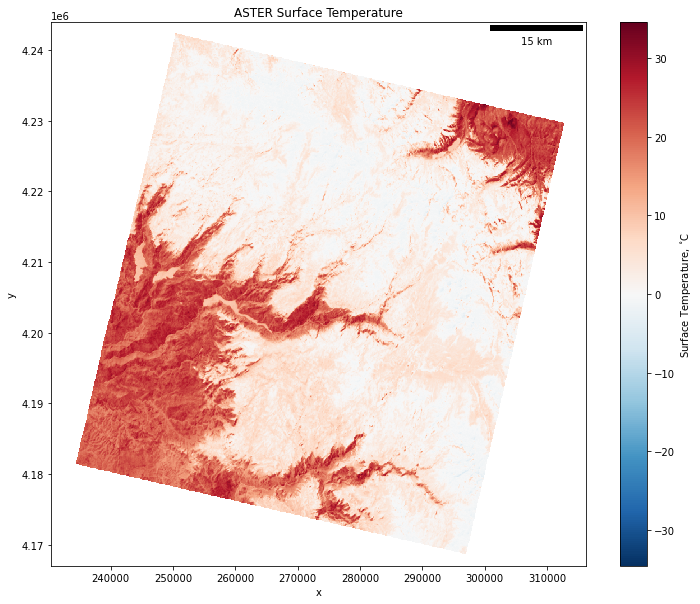

In [35]:
# Plot entire ASTER
%matplotlib inline
f, ax = plt.subplots(figsize=(12,10))
aster_tb_degC.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'})
ax.add_artist(ScaleBar(1.0))
ax.set_title('ASTER Surface Temperature');

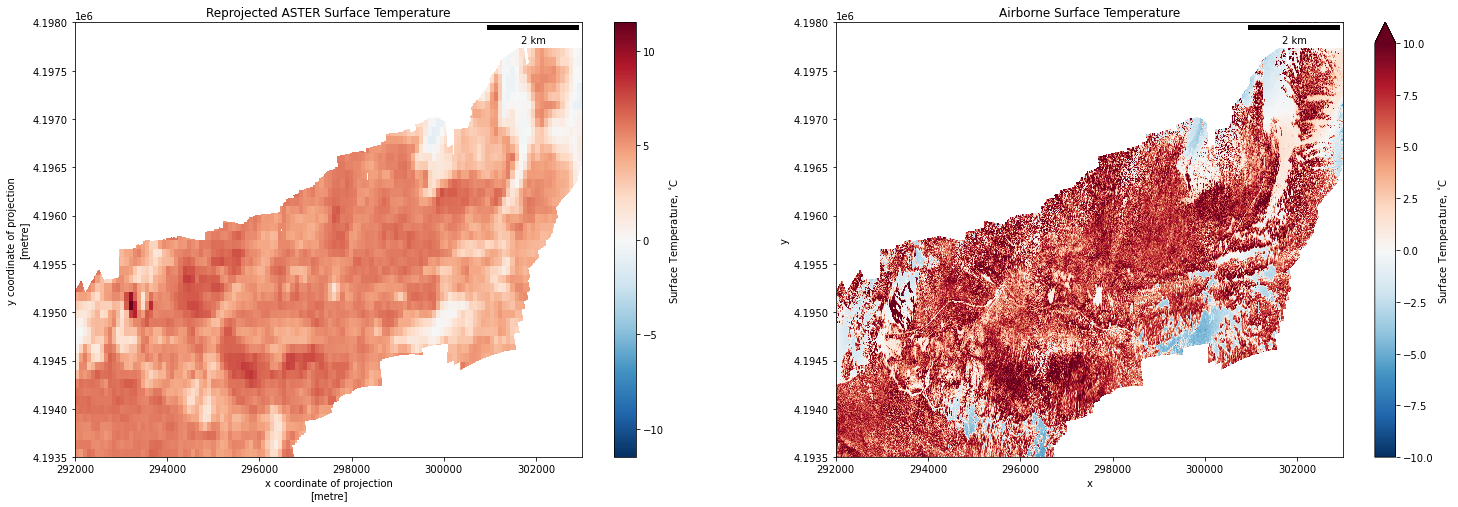

In [45]:
# Plot reprojected ASTER
ASTER_masked = aster_src_repr.where(~np.isnan(air_src))

f, ax = plt.subplots(1,2,figsize=(25,8))

ASTER_masked.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'}, ax=ax[0])
ax[0].add_artist(ScaleBar(1.0))
ax[0].set_title('Reprojected ASTER Surface Temperature')

air_src.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10,ax=ax[1])
ax[1].add_artist(ScaleBar(1.0))
ax[1].set_title('Airborne Surface Temperature');

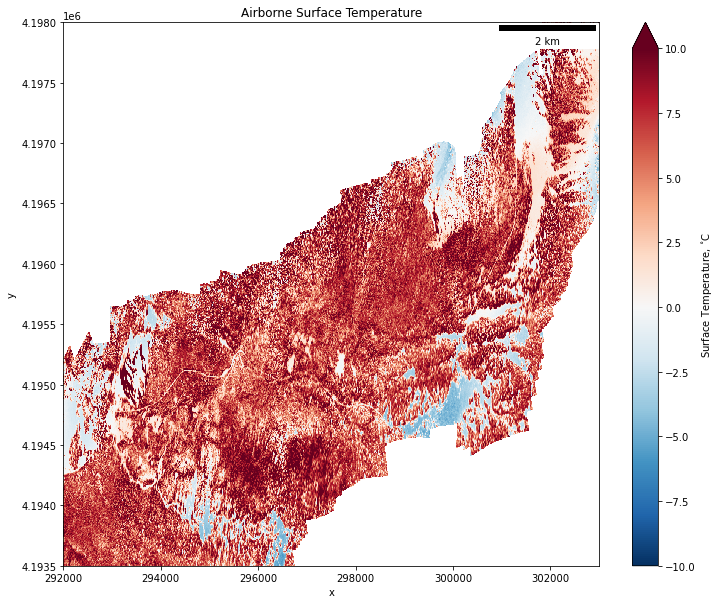

In [40]:
# Plot airborne
f, ax = plt.subplots(figsize=(12,10))
air_src.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10)
ax.add_artist(ScaleBar(1.0))
ax.set_title('Airborne Surface Temperature');

### Calculate and plot difference raster

In [8]:
# Calculate difference map
diff = aster_src_repr-air_src

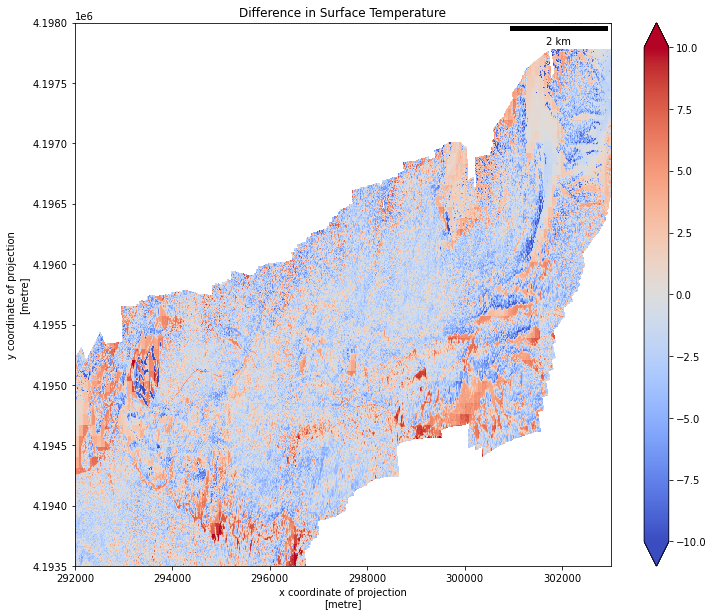

In [46]:
# Plot difference map = how much warmer ASTER is
f, ax = plt.subplots(figsize=(12,10))
diff.plot(cmap='coolwarm',vmin=-10,vmax=10)
ax.add_artist(ScaleBar(1.0))
ax.set_title('Difference in Surface Temperature');

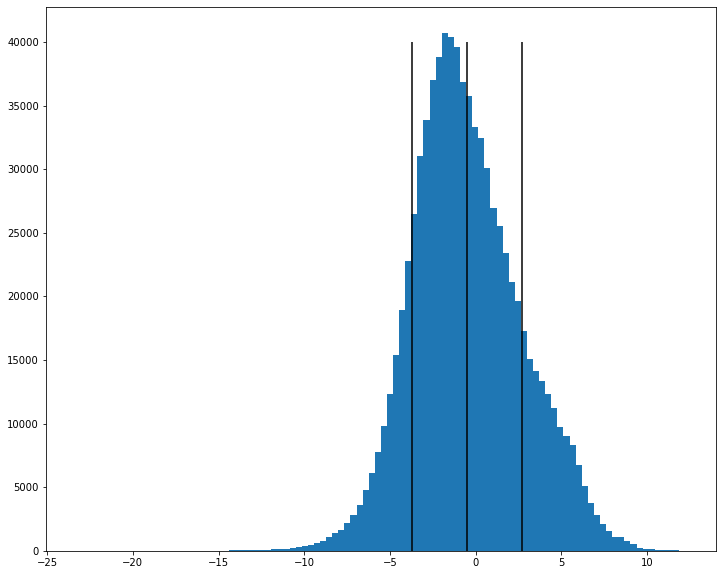

In [59]:
%matplotlib inline
f, ax = plt.subplots(figsize=(12,10))
plt.hist(diff.values.ravel(),bins=100)
ax.vlines(x=diff.mean().item(0),ymin=0,ymax=40000,color='k')
ax.vlines(x=diff.mean().item(0)+diff.std().item(0),ymin=0,ymax=40000,color='k')
ax.vlines(x=diff.mean().item(0)-diff.std().item(0),ymin=0,ymax=40000,color='k')
#ax.vlines(x=diff.mode().item(0),ymin=0,ymax=40000,color='k');

In [61]:
print('Mean difference = ',diff.mean().item(0))
print('Median difference = ',diff.median().item(0))
print('Stdev difference = ', diff.std().item(0))
print('Min difference = ',abs(diff).min().item(0))
print('Max difference = ',abs(diff).max().item(0))

Mean difference =  -0.5203320315839628
Median difference =  -0.8178712773791403
Stdev difference =  3.202577881779505
Min difference =  8.327116347572883e-07
Max difference =  23.293303217818618


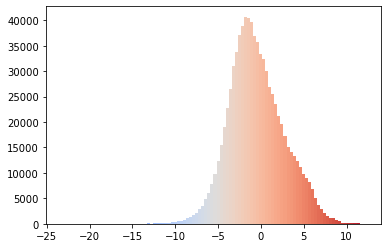

In [12]:
%matplotlib inline
# Plot histogram of differences
cm = plt.cm.coolwarm
n, bins, patches = plt.hist(diff.values.ravel(),bins=100)
# Trying to add colormap but it didn't work
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.show();

In [13]:
#%matplotlib widget

### Calculate and plot NDVI

In [14]:
red_path = './aster/AST_L1T_00304212017185107_20170422082541_26960_ImageData2.tif'
nir_path = './aster/AST_L1T_00304212017185107_20170422082541_26960_ImageData3N.tif'

In [15]:
red_src = xr.open_rasterio(red_path)
nir_src = xr.open_rasterio(nir_path)

red = red_src.rio.reproject_match(air_src)
nir = nir_src.rio.reproject_match(air_src)

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [16]:
NDVI = (nir-red)/(nir+red)

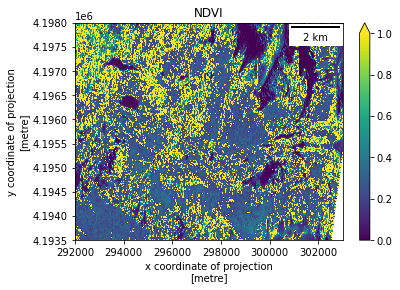

In [17]:
f, ax = plt.subplots()
NDVI.plot(ax=ax,vmin=0,vmax=1)
ax.add_artist(ScaleBar(1.0))
ax.set_title('NDVI');

In [18]:
air_src

<xarray.DataArray (band: 1, y: 901, x: 2201)>
[1983101 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.194e+06 4.194e+06 4.194e+06 ... 4.198e+06 4.198e+06
  * x        (x) float64 2.92e+05 2.92e+05 2.92e+05 ... 3.03e+05 3.03e+05
Attributes:
    transform:         (4.997728305315759, 0.0, 292000.0, 5.528368561547037e-...
    crs:               +init=epsg:26911
    res:               (4.997728305315759, 4.9944506104329776)
    is_tiled:          0
    nodatavals:        (-9999.0,)
    scales:            (1.0,)
    offsets:           (0.0,)
    AREA_OR_POINT:     Area
    TIFFTAG_DATETIME:  2017-04-21T18:47:34.621196

In [20]:
NDVI_masked = NDVI.where(~np.isnan(air_src))

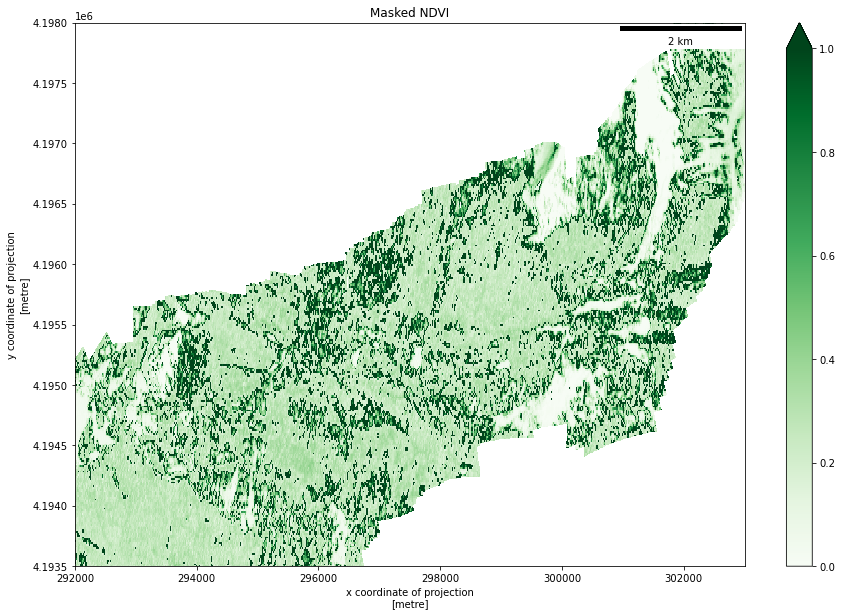

In [66]:
f, ax = plt.subplots(figsize=(15,10))
NDVI_masked.plot(ax=ax, vmin=0, vmax=1,cmap='Greens')
ax.add_artist(ScaleBar(1.0))
ax.set_title('Masked NDVI');

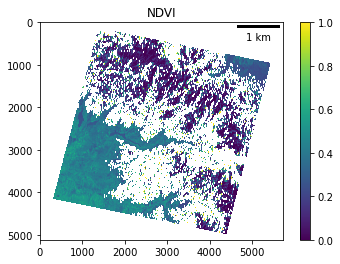

In [22]:
# Check without reprojection
def rio2ma(fn, b=1, window=None):
    #a = None
    with rasterio.open(fn) as src:
        #If working with PAN, scale offset and dimensions by factor of 2
        if 'B8' in fn and window is not None:
            window = rasterio.windows.Window(window.col_off*2, window.row_off*2, window.width*2, window.height*2)
        #Read in the window to masked array
        a = src.read(b, window=window, masked=True)
        return a

red_ma = rio2ma(red_path)
nir_ma = rio2ma(nir_path)
NDVI_ma = (nir_ma-red_ma)/(nir_ma+red_ma)

f, ax = plt.subplots()
ax.imshow(NDVI_ma, vmin=0, vmax=1)
ax.add_artist(ScaleBar(1.0))
ax.set_title('NDVI')
f.colorbar(ax.imshow(NDVI_ma, vmin=0, vmax=1));

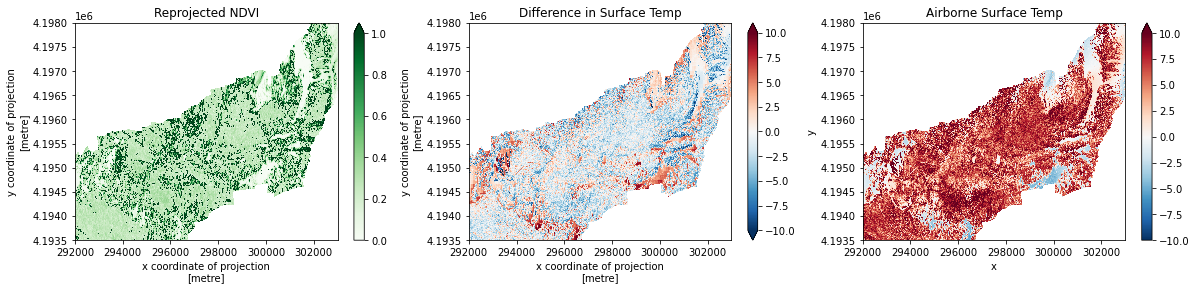

In [23]:
f, [ax1, ax2, ax3] = plt.subplots(1,3,)

NDVI_masked.plot(ax=ax1, vmin=0, vmax=1, cmap='Greens')
ax1.set_title('Reprojected NDVI')
diff.plot(ax=ax2, vmin=-10, vmax=10, cmap='RdBu_r')
ax2.set_title('Difference in Surface Temp')
air_src.plot(ax=ax3, vmin=-10, vmax=10, cmap='RdBu_r')
ax3.set_title('Airborne Surface Temp')

f.set_figwidth(20)
f.set_figheight(4);

In [24]:
air_where_NDVI = air_src.where(~np.isnan(NDVI_masked))

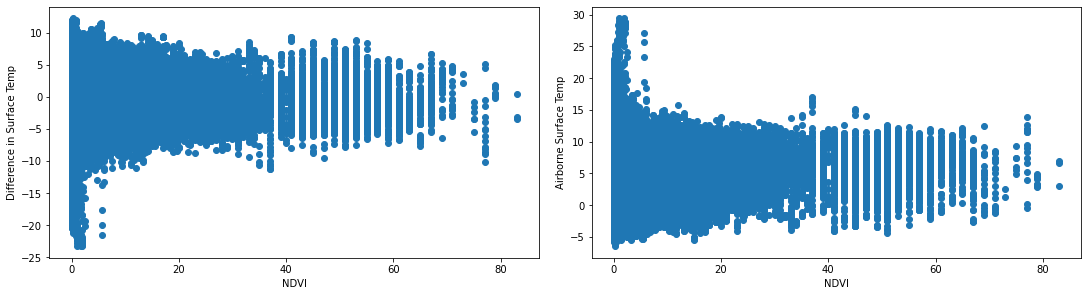

In [25]:
f, [ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(15,4),constrained_layout=True)

ax1.scatter(NDVI_masked,diff)
ax1.set_xlabel('NDVI')
ax1.set_ylabel('Difference in Surface Temp')

ax2.scatter(NDVI_masked,air_where_NDVI)
ax2.set_xlabel('NDVI')
ax2.set_ylabel('Airborne Surface Temp');

Text(0.5, 0, 'Airborne Surface Temp')

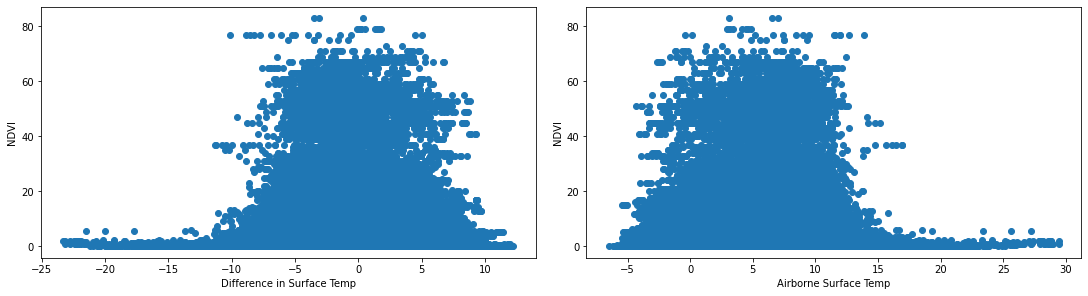

In [71]:
f, [ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(15,4),constrained_layout=True)

ax1.scatter(diff,NDVI_masked)
ax1.set_ylabel('NDVI')
ax1.set_xlabel('Difference in Surface Temp')

ax2.scatter(air_where_NDVI,NDVI_masked)
ax2.set_ylabel('NDVI')
ax2.set_xlabel('Airborne Surface Temp');

In [50]:
B1_diff, B0_diff, R_diff, p_diff, sB1_diff = stats.linregress(NDVI_masked.squeeze(), diff.squeeze())

ValueError: too many values to unpack (expected 4)

In [56]:
NDVI_masked.data

array([[[0.31868132, 0.31868132, 0.31868132, ...,        nan,
                nan,        nan],
        [0.31868132, 0.31868132, 0.31868132, ...,        nan,
                nan,        nan],
        [0.29533679, 0.29533679, 0.29533679, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.02834008,
         0.02834008, 0.        ],
        [       nan,        nan,        nan, ..., 0.02834008,
         0.02834008, 0.        ],
        [       nan,        nan,        nan, ..., 0.04098361,
         0.04098361, 0.02008032]]])